In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import csv
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from numpy import array

from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/RecreatingBestModelCuda.pt'

Mounted at /content/drive


In [ ]:
import torch

def get_next_centre(values, output):
    data = output.data
    for i in range(2, 9):
        if data[i] < 0 and data[i + 1] > 0:
            values[0] = data[i - 2]
            values[1] = data[i - 1]
            values[2] = data[i]
            values[3] = data[i + 1]
            values[4] = data[i + 2]
            values[5] = data[i + 3]
            break

if __name__ == "__main__":
    model_path = r"/content/drive/MyDrive/RecreatingBestModelCuda.pt"
    try:
        model = torch.jit.load(model_path)
        model.eval()
        values = torch.zeros(6)
        output = torch.empty(0)  # Assuming initial output is empty or a specific tensor shape as needed
        for i in range(2000):
            if i == 0:
                values = torch.tensor([-0.7787362, -0.8905415, -0.6589257, 0.62962157, 1.2157797, 2.0017693])
            else:
                get_next_centre(values, output)
            S_t = values.view(1, 6)
            z_t = torch.randn(1, 12)
            output = model.forward(z_t, S_t)[0]
            # Assuming `outputFile` is a file opened in write mode
            with open('/content/drive/MyDrive/new2_bestmodelvalues.csv', 'a') as outputFile:
              output_cpu = output.cpu()  # Move the tensor to CPU
              # To convert to a NumPy array
              numpy_array = output_cpu.detach().numpy()
              output_values = numpy_array.tolist()
              output_values = str(output_values)
              output_values = output_values.replace("[", "")
              output_values = output_values.replace("]", "")
              print(output_values)
              outputFile.write(output_values + "\n")
    except Exception as e:
        print("Error loading the model:", e)

Error loading the model: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# Input and output file names
training_data_path = '/content/drive/My Drive/orderbook_snapshots.csv'
output_filename = '/content/drive/My Drive/realdata.csv'

# Initialise a dictionary to hold the data in correct order
orders = defaultdict(lambda: {"Ask 0": None, "Ask 1": None, "Ask 2": None, "Bid 0": None, "Bid 1": None, "Bid 2": None})

# Read original csv and populate the orders dictionary
with open(training_data_path, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        timestamp, _, price, quantity, order_type = row
        if order_type == '0_ask':
            orders[timestamp]["Ask 0"] = quantity
        elif order_type == '1_ask':
            orders[timestamp]["Ask 1"] = quantity
        elif order_type == '2_ask':
            orders[timestamp]["Ask 2"] = quantity
        elif order_type == '0_bid':
            orders[timestamp]["Bid 0"] = quantity
        elif order_type == '1_bid':
            orders[timestamp]["Bid 1"] = quantity
        elif order_type == '2_bid':
            orders[timestamp]["Bid 2"] = quantity

# Write the data to a new csv file
with open(output_filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Timestamp', "Ask 0", "Ask 1",  "Ask 2", "Bid 0", "Bid 1",  "Bid 2"])
    for timestamp, order in orders.items():
        writer.writerow([timestamp, order[ "Ask 0"], order[ "Ask 1"], order[ "Ask 2"], order[ "Bid 0"], order[ "Bid 1"], order[ "Bid 2"]])

data_path = output_filename
columns = ['Timestamp', "Ask 0", "Ask 1",  "Ask 2", "Bid 0", "Bid 1",  "Bid 2"]
real_data = pd.read_csv(data_path, header=None, names=columns, skiprows=1)
date_time = real_data.pop('Timestamp')

# Normalize the dataset
def normalization(X_train, c=8):
    sqrt_abs_over_c = np.sqrt(np.abs(X_train)) / c
    with_sign = np.sign(X_train) * sqrt_abs_over_c
    return with_sign

#real_data = normalization(real_data)
real_data = real_data.sample(n=2000, random_state=10)
real_data

,Ask 0,Ask 1,Ask 2,Bid 0,Bid 1,Bid 2
26879,1.612500,4.039684,8.898170,2.312724,8.288861,2.946722
15076,11.158866,1.198212,16.353521,15.000000,2.068171,12.307098
72376,12.756624,3.705682,21.194379,1.552825,1.407456,3.102102
58129,3.080209,8.231007,4.384393,16.203550,2.343874,3.324190
57037,9.894215,3.889119,7.751195,2.293355,0.545098,22.979847
...,...,...,...,...,...,...
16758,13.822867,2.391358,12.068911,0.149999,0.505895,0.314091
72640,0.743340,1.620467,6.617314,6.060195,2.161218,14.276317
4034,3.102928,8.972609,11.533981,7.664209,26.890249,15.062591
59484,1.790371,1.459107,6.584349,0.506504,3.693504,4.637640


In [ ]:
model_output = pd.read_csv('/content/drive/MyDrive/new2_bestmodelvalues.csv', names=["Ask 0", "Ask 1", "Ask 2", "Ask 3", "Ask 4",  "Ask 5", "Bid 0", "Bid 1", "Bid 2", "Bid 3", "Bid 4",  "Bid 5"])
model_output

def reverse_normalization(X_train_normalized, c=8):
    unscaled_data = X_train_normalized * c
    X_train = np.sign(X_train_normalized) * (unscaled_data ** 2)
    return X_train

three_bid_asks = model_output.drop(columns=["Ask 3", "Ask 4",  "Ask 5","Bid 3", "Bid 4",  "Bid 5"])

gen_data = three_bid_asks
gen_data

,Ask 0,Ask 1,Ask 2,Bid 0,Bid 1,Bid 2
0,-2.430931,-0.731971,-1.977135,1.331392,3.706016,1.783209
1,-1.404020,-1.085307,-2.149389,0.747307,0.870673,1.960740
2,-1.497706,-0.443140,-1.753570,0.739577,1.001832,1.825022
3,-0.942621,-1.629483,-0.617078,0.610615,1.007615,1.464903
4,-1.383826,-2.049907,-1.561993,0.735186,1.065917,1.339221
...,...,...,...,...,...,...
1996,-3.748644,-0.174053,-0.046611,0.830955,10.759581,6.605386
1997,-0.321761,-3.375313,0.536585,0.405041,13.196663,5.167441
1998,-1.750573,-3.503272,-0.254865,0.904140,15.489239,3.776495
1999,-2.045823,-1.651344,-0.824592,2.991385,14.652310,3.915960


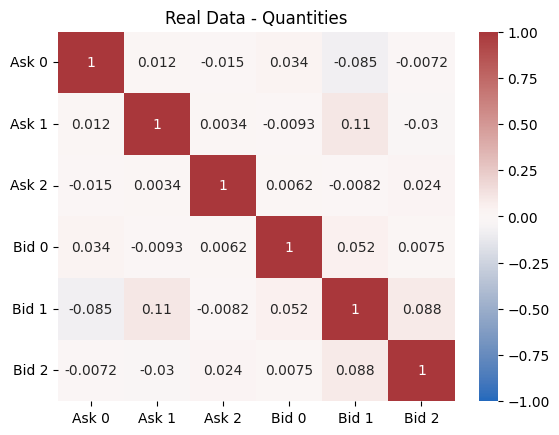

In [ ]:
# Correlation structure of Real order quantities
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
dataset = datasets. load_iris ()
matrix = real_data.corr()

fig, ax = plt.subplots(1,1)

#plotting correlation matrix
img = sns.heatmap(matrix,annot=True, vmin=-1, vmax=1, cmap='vlag')

#extracting variable names
variables = []
for i in matrix.columns:
  variables.append(i)

# Adding labels to the matrix
plt.xticks(np.arange(6)+0.5, variables, rotation=0, fontsize="10", va="top")
plt.yticks(np.arange(6)+0.5, variables, rotation=0, fontsize="10", va="center")
plt.title('Real Data - Quantities')
# Display the plot
plt.show()

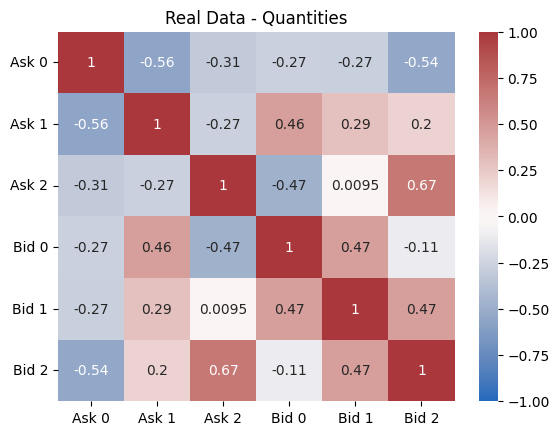

In [ ]:
# Correlation structure of generated order quantities
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
dataset = datasets. load_iris ()
matrix = three_bid_asks.corr()

fig, ax = plt.subplots(1,1)

#plotting correlation matrix
img = sns.heatmap(matrix,annot=True, vmin=-1, vmax=1, cmap='vlag')

#extracting variable names
variables = []
for i in matrix.columns:
  variables.append(i)

# Adding labels to the matrix
plt.xticks(np.arange(6)+0.5, variables, rotation=0, fontsize="10", va="top")
plt.yticks(np.arange(6)+0.5, variables, rotation=0, fontsize="10", va="center")
plt.title('Real Data - Quantities')
# Display the plot
plt.show()

## Probability of a positive price change

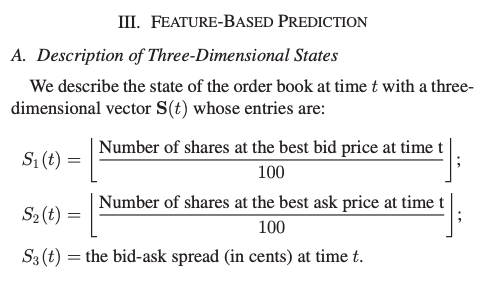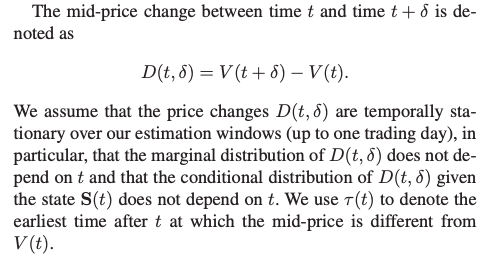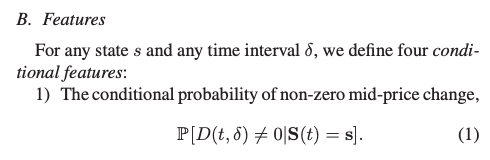

In [ ]:
gr = np.array_split(three_bid_asks, 10)

for grp in gr:
    print(f'\nGroup: {grp}')


Group:         Ask 0     Ask 1     Ask 2     Bid 0     Bid 1     Bid 2
0   -2.430931 -0.731971 -1.977135  1.331392  3.706016  1.783209
1   -1.404020 -1.085307 -2.149389  0.747307  0.870673  1.960740
2   -1.497706 -0.443140 -1.753570  0.739577  1.001832  1.825022
3   -0.942621 -1.629483 -0.617078  0.610615  1.007615  1.464903
4   -1.383826 -2.049907 -1.561993  0.735186  1.065917  1.339221
..        ...       ...       ...       ...       ...       ...
196 -1.709996 -0.807681 -0.611025  0.880050  1.287477  1.611878
197 -1.605170 -2.270715 -0.806820  0.876536  1.337572  1.654050
198 -2.232826 -1.165100 -2.264424  0.870013  1.328149  1.724202
199 -0.939611 -2.287443 -1.738313  0.892288  1.296567  1.783554
200 -0.865734 -2.820759 -1.109146  0.960082  1.186445  1.799131

[201 rows x 6 columns]

Group:         Ask 0     Ask 1     Ask 2     Bid 0     Bid 1     Bid 2
201 -2.439456 -2.495982 -1.492241  0.918691  1.205818  1.619732
202 -2.255651 -1.789461 -1.452221  0.953493  1.387152  1.424564


In [ ]:
# pre-sort array
sorted_df_ask = gen_data.sort_values(by=['Ask 0'], ascending=False)
gr = np.array_split(sorted_df_ask, 10)

for grp in gr:
    print(f'\nGroup: {grp}')

ask_quantile_0 = gr[0]
ask_quantile_1 = gr[1]
ask_quantile_2 = gr[2]
ask_quantile_3 = gr[3]
ask_quantile_4 = gr[4]
ask_quantile_5 = gr[5]
ask_quantile_6 = gr[6]
ask_quantile_7 = gr[7]
ask_quantile_8 = gr[8]
ask_quantile_9 = gr[9]

# pre-sort bids
sorted_df_bid = gen_data.sort_values(by=['Bid 0'], ascending=False)
gr2 = np.array_split(sorted_df_bid, 10)

for grp in gr2:
    print(f'\nGroup: {grp}')

bid_quantile_0 = gr2[0]
bid_quantile_1 = gr2[1]
bid_quantile_2 = gr2[2]
bid_quantile_3 = gr2[3]
bid_quantile_4 = gr2[4]
bid_quantile_5 = gr2[5]
bid_quantile_6 = gr2[6]
bid_quantile_7 = gr2[7]
bid_quantile_8 = gr2[8]
bid_quantile_9 = gr2[9]



Group:          Ask 0     Ask 1     Ask 2     Bid 0      Bid 1     Bid 2
120   1.090858 -3.412453  0.497083 -0.195324  -1.539269  1.794570
245   0.835328 -3.285891  0.359868  0.427616  -0.979938  2.222242
1946  0.646793 -1.051339 -0.700285  2.676647  11.052741  2.003461
454   0.476948 -1.508191 -1.118219 -1.291093   0.275423 -0.120545
448   0.320942 -1.721857 -0.524301  0.156929  -0.463848  0.414075
...        ...       ...       ...       ...        ...       ...
390  -0.870171 -1.332581 -1.404272 -0.175538   6.153166  1.667304
985  -0.872002 -3.943235 -0.167606  0.250835   8.180878  2.944612
489  -0.872239 -2.604475 -1.299203  1.032061   2.259368  1.195097
1071 -0.873219 -1.375425 -2.601834  1.015930   1.664284  1.654948
172  -0.874451 -2.071186 -1.489589  0.851980   1.416797  1.311067

[201 rows x 6 columns]

Group:          Ask 0     Ask 1     Ask 2     Bid 0      Bid 1     Bid 2
158  -0.875465 -0.778666 -2.163091  1.047937   0.496881  1.430468
1200 -0.876578 -2.060984 -1.934540  

In [ ]:
# FINAL FORMULA JUST SWITCH THE QUANTILES.
# In particular, the higher the imbalance between bid and ask side of the order book, the more likely is a price change towards the direction of the smaller queue
# Figure 8 shows that the generator, solely learning the process of the queues in the order book, accurately reflects the different probabilities of prices changes.
# Figure 8: Matrix indicating the probability of a positive price change, given there is a price change,
# as a function of the quantiles of the best bid/best ask queues. Left: Real, right: Fake.
# Upper left square indicates probability for a price change to be positive if both bid and ask queues are in the bucket between the corresponding 0% and 10% quantile.

mid_price_list = []
d_ts = []
total_changes = 0
total_pos_changes = 0

# calculate the mid price and the mid_price change
for i in range(0, len(ask_quantile_1)-1):
  current_ask = ask_quantile_0.iloc[i]
  current_bid = bid_quantile_9.iloc[i]

  next_ask = ask_quantile_0.iloc[i+1]
  next_bid = bid_quantile_9.iloc[i+1]

  current_queue = pd.concat([current_ask, current_bid], axis=0)
  next_queue = pd.concat([next_ask, next_bid], axis=0)

  curr_neg_count = len(list(filter(lambda x: (x < 0), current_queue)))
  curr_pos_count = len(list(filter(lambda x: (x > 0), current_queue)))

  next_neg_count = len(list(filter(lambda x: (x < 0), next_queue)))
  next_pos_count = len(list(filter(lambda x: (x > 0), next_queue)))

  if  curr_pos_count > next_pos_count or  next_pos_count > curr_pos_count:
    val = next_pos_count - curr_pos_count
    d_ts.append(val)

# calculate the probability of a positive change in this quantile
# the total number of positive changes / number of changes
total_positive = 0
total_changes = 0
for i in range(0, len(d_ts)-1):
  if d_ts[i] > 0:
    total_positive += 1
  if (d_ts[i] < 0 or d_ts[i] > 0) and  d_ts[i] != 0:
    total_changes += 1

probability_pos_change = total_positive/total_changes
print(probability_pos_change)


0.5142857142857142


In [ ]:
# IGNORE

# for the ask quartile X and bid quartile X

mid_price_list = []
d_ts = []

total_changes = 0
total_pos_changes = 0

# calculate PROBABILITY of positive change in bins
for i in range(1, len(ask_quantile_1)):
  current_queue = ask_quantile_0.iloc[i-1]
  next_queue = bid_quantile_9.iloc[i]

  curr_neg_count = len(list(filter(lambda x: (x < 0), current_queue)))
  curr_pos_count = len(list(filter(lambda x: (x >= 0), current_queue)))

  next_neg_count = len(list(filter(lambda x: (x < 0), next_queue)))
  next_pos_count = len(list(filter(lambda x: (x >= 0), next_queue)))

  if curr_pos_count > next_pos_count:
    total_pos_changes += 1
  if  curr_pos_count > next_pos_count or  next_pos_count > curr_pos_count:
    total_changes += 1

print(i)
probability = total_pos_changes / total_changes
print(total_pos_changes, total_changes)
print(probability)
# calculate the probability of a positive mid_price change in this quartile
# the total number of positive mid_price changes / number of mid_price change

199
6 102
0.058823529411764705


In [ ]:
# IGNORE

# In particular, the higher the imbalance between bid and ask side of the order book, the more likely is a price change towards the direction of the smaller queue
# Figure 8 shows that the generator, solely learning the process of the queues in the order book, accurately reflects the different probabilities of prices changes.
# Figure 8: Matrix indicating the probability of a positive price change, given there is a price change,
# as a function of the quantiles of the best bid/best ask queues. Left: Real, right: Fake.
# Upper left square indicates probability for a price change to be positive if both bid and ask queues are in the bucket between the corresponding 0% and 10% quantile.

d_ts = []

total_changes = 0
total_pos_changes = 0

for i in range(1, len(ask_quantile_1)):

  current_queue_ask = ask_quantile_5.iloc[i-1]
  current_queue_bid = bid_quantile_5.iloc[i-1]

  next_queue_ask = ask_quantile_5.iloc[i]
  next_queue_bid = bid_quantile_5.iloc[i]

  current_queue = pd.concat([current_queue_ask, current_queue_bid], axis=0)
  next_queue = pd.concat([next_queue_ask, next_queue_bid], axis=0)

  curr_neg_count = len(list(filter(lambda x: (x < 0), current_queue)))
  curr_pos_count = len(list(filter(lambda x: (x > 0), current_queue)))

  next_neg_count = len(list(filter(lambda x: (x < 0), next_queue)))
  next_pos_count = len(list(filter(lambda x: (x > 0), next_queue)))

  if curr_pos_count > next_pos_count:
    total_pos_changes += 1
  if  curr_pos_count > next_pos_count or  next_pos_count > curr_pos_count:
    total_changes += 1

print(i)
probability = total_pos_changes / total_changes
print(total_pos_changes, total_changes)
print(probability)

199
44 91
0.4835164835164835
